## Exploring MNIST

The MNIST dataset consists of hand-written digits. The sklearn library contains a smaller version of this dataset consisting of 1797 8x8 images with entries consisting of grayscale values 0-15.

In [117]:
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model.perceptron import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()

First let's get a feel for the data set, by plotting the first 10 images

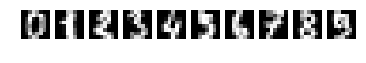

In [118]:
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.set_axis_off()
    ax.imshow(digits['images'][i], cmap='gray', interpolation='none')
fig.show()


Our goal is to classify the digit (0-9) from the image. We will test various classification algorithms. We split our data into a 80-20% split, and use the smaller data set to assess the performance of our algorithms.

In [119]:
np.random.seed(0)
train, test, target_train, target_test = train_test_split(digits['data'], digits['target'], test_size=0.2) 

## The Perceptron

The perceptron is a very simple linear classification algorithm. For a two class classification problem, $\hat y \in \left\{ 0,1 \right\}$ we fit a model of the form

$$ \hat y = \phi( \mathbf{w}^T \mathbf{x}) $$

where $\phi$ is the heaviside step function. Although this is a non-probabilistic discriminant function, the certainty of the prediction is given by the magnitude $|\mathbf{w}^T \mathbf{x}|$. 

This can be extended to a multi-class classifier using the one-versus-rest paradigm.

In [120]:
p =  Perceptron()
p.fit(train, target_train)
p_predict = p.predict(test)
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test, p_predict))
#print confusion_matrix(target_test, p_predict)

Percentage Accuracy: 93.3%


## Logistic Regression

Multi-class logistic regression fits a model of the form

$$ p(C_k | x) = y_k(x) = \sigma(\mathbf{W}^T \mathbf{x})_k $$

where $\sigma \colon \mathbb{R}^N \to [0,1]^N$ is the soft-max function on $N$ classes. We choose our weights $\mathbf{W}$ to minimize the cross-entropy loss function with L2 regularisation. We withhold a separate validation set of the same size as the test set which we use the choose our regularisation parameter $\lambda$.

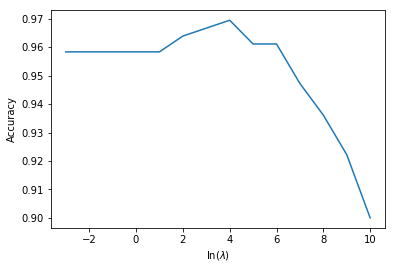

In [121]:
np.random.seed(0)
train_small, validate, target_train_small, target_validate = train_test_split(train, target_train, test_size=0.25)

# Use the validation set to find a good choice of the regularisation parameter 
# C = 1 / lambda
ln_lambdas = np.arange(-3, 11 , 1) 
accuracies = np.zeros(len(ln_lambdas))
for i, lmbda in enumerate(ln_lambdas):

    reg = LogisticRegression(C=1.0/np.exp(lmbda), multi_class='multinomial', solver='newton-cg')
    reg.fit(train_small, target_train_small)
    predict = reg.predict(validate)
    accuracies[i] = accuracy_score(target_validate, predict)

fig = plt.figure()
plt.plot(ln_lambdas, accuracies)
plt.xlabel(r'$\ln(\lambda)$')
plt.ylabel('Accuracy')
fig.show()

In [122]:
# Train a model with an optimal regularisation parameter
lmbda = np.exp(ln_lambdas[accuracies.argmax()])
reg = LogisticRegression(C=1.0/lmbda, multi_class='multinomial', solver='newton-cg')
reg.fit(train_small, target_train_small)
reg_predict = reg.predict(test)
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test, reg_predict))
#print confusion_matrix(target_test, reg_predict)

Percentage Accuracy: 95.8%


Not only does this model give us greater accuracy than the perceptron, it also gives the probability our prediction is correct which we can combine with decision theory to make optimal decisions. As a simple example, we can only make predictions on those digits which we are confident ($> 90\%$ probability) as follows.

In [123]:
confident_ix = reg.predict_proba(test).max(axis=1) > 0.9
print "Confident on {0} out of {1}".format(sum(confident_ix), len(test))
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test[confident_ix], reg_predict[confident_ix]))
#print confusion_matrix(target_test[confident_ix], reg_predict[confident_ix])

Confident on 296 out of 360
Percentage Accuracy: 99.3%


## Linear Discriminant Analysis

In LDA, we make the assumption that our data for each class is normally distributed with the same covariance matrix for each class. Explicitly,

$$ p(\mathbf{x} | C_k) = \mathcal{N}(\mu_k, \mathbf{\Sigma}) $$

We can then use Bayes' theorem to compute the predictive probabilities:

$$ p(C_k | \mathbf{x}) = \frac{p(\mathbf{x} | C_k) p(C_k)}{p(\mathbf{x})} = \frac{p(\mathbf{x} | C_k) p(C_k)}{\sum_j p(\mathbf{x} | C_j) p(C_j)} $$

where we obtain the priors $p(C_k)$ to be the proportion of our data belonging to each class. Picking the class with the largest conditional probability results in a linear decision boundary.





In [124]:
lda = LinearDiscriminantAnalysis()
lda.store_covariance = True
lda.fit(train, target_train)
lda_predict = lda.predict(test)
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test, lda_predict))
#print confusion_matrix(target_test, lda_predict)

Percentage Accuracy: 95.0%


LDA can also be used to perform supervised dimensionality reduction.

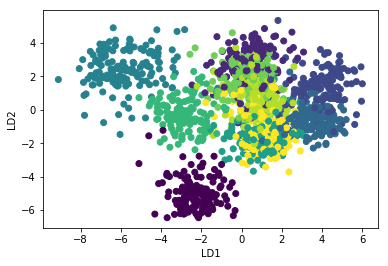

In [125]:
lda.n_components = 2
lda_transform = lda.transform(train)

fig = plt.figure()
plt.scatter(lda_transform[:,0], lda_transform[:,1], c=target_train)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()

LDA is what is known as a generative model, since we explicit model the joint distribution $p(x, C_k)$. As a result, we can sample from this distribution and produce new digits.

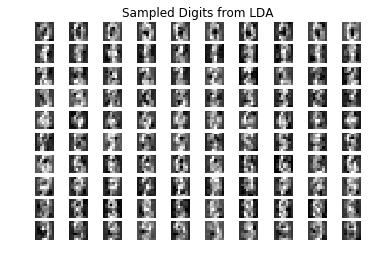

In [127]:
fig = plt.figure()
n_samples = 10
np.random.seed(0)
for digit in range(10):
    samples = np.random.multivariate_normal(lda.means_[digit], lda.covariance_, n_samples)
    for i in range(n_samples):
        ax = fig.add_subplot(10, n_samples, 1 + digit*n_samples + i)
        ax.set_axis_off()
        ax.imshow(samples[i].reshape((8,8)), cmap='gray', interpolation='none')
ax = fig.add_subplot(1,1,1)
ax.set_title('Sampled Digits from LDA')
ax.set_axis_off()
fig.show()

## Quadratic Disciminant Analysis

For QDA we still assume that our the class-conditional data is normally distributed, but we relax the assumption that the covariance matrices are equal across classes. As a result we obtain quadratic decision boundaries.

In [129]:
qda = QuadraticDiscriminantAnalysis()
qda.store_covariances = True
qda.fit(train, target_train)
qda_predict = qda.predict(test)
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test, qda_predict))
#print confusion_matrix(target_test, qda_predict)

Percentage Accuracy: 88.6%


At first it may seem surprising that QDA is less accurate than LDA since QDA is a more flexible model. However, this increased flexibility allows us to overfit our model for the training data. In LDA we estimate the 10 class means, and a single covariance matrix, for a total of $10 \times 64 + \frac{1}{2} \times 65 \times 64 = 2720$ parameters. However, in QDA we are estimating an addtional 9 covariance matrices for a total of $2720 + 9 \times \frac{1}{2} \times 65 \times 64 = 21440$ parameters. 

However, while this extra flexibility decreases the classification accuracy, it increases the generative power and if we use this distribution to generate images, they look a lot more realistic.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


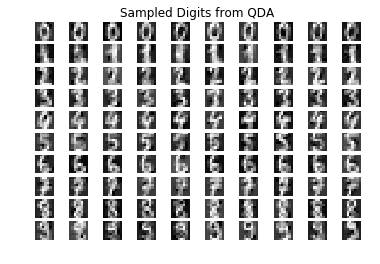

In [131]:
fig = plt.figure()
np.random.seed(0)
for digit in range(10):
    samples = np.random.multivariate_normal(qda.means_[digit], qda.covariances_[digit], n_samples)
    for i in range(n_samples):
        ax = fig.add_subplot(10, n_samples, 1 + digit*n_samples + i)
        ax.set_axis_off()
        ax.imshow(samples[i].reshape((8,8)), cmap='gray', interpolation='none')
ax = fig.add_subplot(1,1,1)
ax.set_title('Sampled Digits from QDA')
ax.set_axis_off()
fig.show()

In both the LDA and QDA models, we made the strong assumption that the distribution of the data in each class is normal. To check this assumption, we plot a histogram of the grayscale values at each pixel for a fixed digit. Since the marginal distribution of a Gaussian, $p(x_i | C_k) = \int_{j \neq i} p(\mathbf{x}| C_k) dx_j$, is also gaussian, we would expect our histograms to be Gaussian.

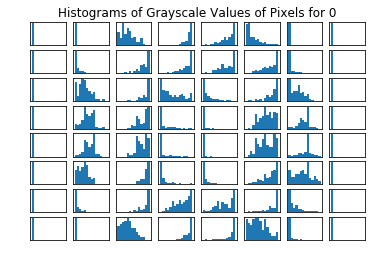

In [116]:
digit = 0
fig = plt.figure()
for i in range(64):
    data = train[target_train == digit]
    ax = fig.add_subplot(8,8, i+1)
    tmp, tmp, tmp = ax.hist(data[:,i], bins=np.arange(0, 15))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
ax = fig.add_subplot(1,1,1)
ax.set_axis_off()
ax.set_title('Histograms of Grayscale Values of Pixels for {0}'.format(digit))
fig.show()

While some of these histograms exhibit Gaussian like behaviour, several of them don't and so our assumption about the distribution of our data seems to be incorrect. However, we could still get some nice results under this assumption.

## Naive Bayes

Let's force the data to fit a distribution we can understand, we might imagine that the intermediate grayscale values are artifacts of anti-aliasing rather than important information. Under this assumption, we can convert our digits into binary images by setting a pixel to be on if the grayscale value is at least 8 and off otherwise. We can see the effect this has below.

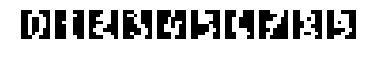

In [132]:
bin_train, bin_test = (train >=8).astype(int), (test>=8).astype(int)

# Plot the first few images
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.set_axis_off()
    ax.imshow((digits['data'][i] >= 8).astype(int).reshape((8,8)), cmap='gray', interpolation='none')
fig.show()

Now each pixel in our image has a Bernoulli distribution. To specify a general distribution from which binary images are drawn would require a list of $2^{64}$ probabilities. This is far too many $(2^{64}-1)$ free parameters, and so we make the (Naive Bayes) assumption that within class the value of each pixel is independent of the other pixels. Explicitly,

$$ p(\mathbf{x} | C_k) = \prod_{i=1}^{64} \mu_{i,k}^{x_i} (1 - \mu_{i,k})^{1-x_i} $$

This model has $10 \times (64 - 1) = 630$ free parameters and is implemented in scikit-learn as a Bernoulli Naive Bayes model.

In [133]:
nb = BernoulliNB()
nb.fit(bin_train, target_train)
nb_predict = nb.predict(bin_test)
print "Percentage Accuracy: {0:.1f}%".format(100*accuracy_score(target_test, nb_predict))
#print confusion_matrix(target_test, nb_predict)

Percentage Accuracy: 91.1%


Unfortunately our accuracy has not improved. C'est la vie. This could be due to the Naive Bayes assumption, or by the loss of information in the conversion to binary images. The Naive Bayes assumption seems extremely weak in this example: locality is extremely important in image data as illustrated by the efficacy of Convolutional Neural Networks.

I hope you enjoyed this iPython notebook, I'm still trying to learn this stuff, so I'd be very happy to hear any feedback via e-mail at w.mycroft@sheffield.ac.uk